In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.compose import ColumnTransformer

import joblib

import matplotlib.pyplot as plt
import seaborn as sns
import os
import time

In [2]:
cwd = os.getcwd()

In [6]:
parent_dir = os.path.dirname(cwd)
grandparent_dir = os.path.dirname(parent_dir)
grandparent_dir = os.path.dirname(grandparent_dir)

In [7]:
trained_pipeline = joblib.load(f'{parent_dir}/Models/SVM_OpenSmile_Rec_Only.pkl')

In [8]:
import opensmile
from sklearn.base import BaseEstimator, TransformerMixin

In [9]:
def get_audio_file_paths(audio_dir, file_extension=".wav"):
    # List all files in the directory with the given extension
    file_paths = glob.glob(os.path.join(audio_dir, f'*{file_extension}'))
    return file_paths

In [10]:
class FeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.smile = opensmile.Smile(
        feature_set=opensmile.FeatureSet.eGeMAPSv02,
        feature_level=opensmile.FeatureLevel.Functionals,
    )

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Extract features for each audio file and convert to DataFrame
        features_list = [self.smile.process_file(file_path) for file_path in X]
        # Concatenate all extracted features into a single DataFrame
        features_df = pd.concat(features_list, axis=0, ignore_index=True)
        return features_df

In [11]:
class CombinedFeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, audio_column='filename', include_columns=None, audio_dir=''):
        self.audio_column = audio_column
        self.include_columns = include_columns  # Columns to include from the DataFrame
        self.audio_dir = audio_dir

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        

        # Extract filenames from the DataFrame
        file_paths = X[self.audio_column].tolist()
        file_paths = [f'{audio_dir}\\{file}.wav' for file in file_paths]
        
        num_samples = len(file_paths)

        
              
        included_features = X.loc[:, X.columns.isin(self.include_columns)]

        
        
        # Extract audio features
        audio_feature_extractor = FeatureExtractor()
        audio_features = audio_feature_extractor.transform(file_paths)

        
        
        # Combine audio features with the included demographic and symptom features
        combined_features = pd.concat([audio_features, included_features.reset_index(drop=True)], axis=1)

        
        
        return combined_features


In [12]:
audio_dir = f'{grandparent_dir}\\Audio\\'

In [13]:
input_features = trained_pipeline.feature_names_in_

In [14]:
# Define the combined feature extractor with specified columns
combined_feature_extractor = CombinedFeatureExtractor(
    audio_dir=audio_dir,
    audio_column='filename',
    include_columns=input_features
)

In [15]:
# Define the pipeline
new_pipeline = Pipeline([
    ('features', combined_feature_extractor),
    ('existing', trained_pipeline)  # This is your classifier pipeline
])

In [16]:
demographics = pd.read_pickle(f'{grandparent_dir}/Audio/medicalhistory.pkl')
demographics = demographics.drop(['ID', 'Disease category', 'pathology'], axis=1)
demographics = demographics.reset_index()

In [17]:
test_files = demographics.loc[0:2]
test_files

,index,Sex,Age,Narrow pitch range,Decreased volume,Fatigue,Dryness,Lumping,Heartburn,Choking,...,Noise at work,Occupational vocal demand,Diabetes,Hypertension,CAD,Head and Neck Cancer,Head injury,CVA,Voice handicap index - 10,filename
0,0,1,97,0,0,0,0,0,0,1,...,1,2,0,0,0,0,0,0,12,Atrophy-00002mg
1,1,1,86,0,0,0,0,0,0,1,...,1,4,0,1,0,0,0,1,36,Atrophy-0001297
2,2,2,45,0,0,0,1,0,0,0,...,1,3,0,0,0,0,0,0,16,Atrophy-0001apo


In [18]:
combined_feature_extractor.transform(test_files)

,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope,F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope,...,slopeUV0-500_sma3nz_amean,slopeUV500-1500_sma3nz_amean,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp
0,34.883045,0.017140,34.455215,34.960484,35.348808,0.893593,12.763138,4.539836,9.080422,7.009194,...,0.00000,0.000000,0.000000,2.512563,0.518135,1.92,0.00000,0.000000,0.000000,-17.993633
1,29.470533,0.265424,23.582479,31.078848,36.680908,13.098429,22.764477,82.978889,60.700874,12.533890,...,-0.04017,-0.004364,0.569495,3.030303,3.260870,0.16,0.07874,0.123333,0.090308,-16.225655
2,37.683495,0.003717,37.581398,37.688583,37.774849,0.193451,2.640856,1.785011,0.939009,0.305288,...,0.00000,0.000000,0.000000,3.010033,0.341297,2.92,0.00000,0.000000,0.000000,-28.936941


In [19]:
y_pred = new_pipeline.predict(test_files)
y_pred

array(['Benign', 'Benign', 'Benign'], dtype=object)

In [20]:
feature = 'OpenSmile'
models = ['SVM', 'LR', 'NN']
inputs = ['Rec_Only', 'Age_Sex', 'Age_Sex_Symptoms', 'Symptoms']

In [23]:
prediction_times = {}
for model in models:
    for input_val in inputs:
        classifier_name = f'{model}_{feature}_{input_val}.pkl'
        prediction_times[classifier_name] = []
        print(classifier_name)
        trained_pipeline = joblib.load(f'{parent_dir}/Models/{classifier_name}')
        input_features = trained_pipeline.feature_names_in_

        # Define the combined feature extractor with specified columns
        combined_feature_extractor = CombinedFeatureExtractor(
            audio_dir=audio_dir,
            audio_column='filename',
            include_columns=input_features
        )

        # Define the pipeline
        new_pipeline = Pipeline([
            ('features', combined_feature_extractor),
            ('existing', trained_pipeline)  # This is your classifier pipeline
        ])
        
        for i in range(len(demographics)):
            start = time.time()
            y_pred = new_pipeline.predict(demographics.loc[i:i])
            end = time.time()
            prediction_times[classifier_name].append(end - start)

SVM_OpenSmile_Rec_Only.pkl
SVM_OpenSmile_Age_Sex.pkl
SVM_OpenSmile_Age_Sex_Symptoms.pkl
SVM_OpenSmile_Symptoms.pkl
LR_OpenSmile_Rec_Only.pkl
LR_OpenSmile_Age_Sex.pkl
LR_OpenSmile_Age_Sex_Symptoms.pkl
LR_OpenSmile_Symptoms.pkl
NN_OpenSmile_Rec_Only.pkl
NN_OpenSmile_Age_Sex.pkl
NN_OpenSmile_Age_Sex_Symptoms.pkl
NN_OpenSmile_Symptoms.pkl


In [24]:
joblib.dump(prediction_times, 'OpenSmilePredictionTimes.pkl')

['OpenSmilePredictionTimes.pkl']

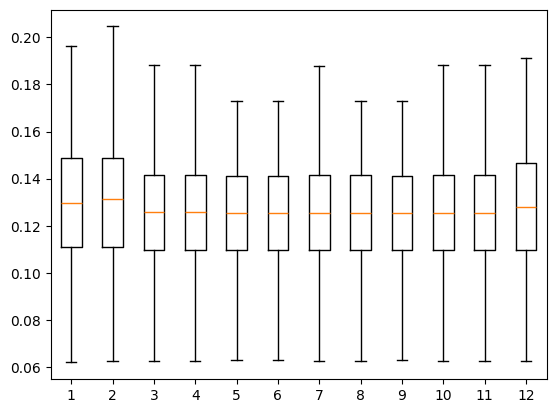

In [25]:
plt.boxplot(prediction_times.values(), showfliers=False)
plt.show()

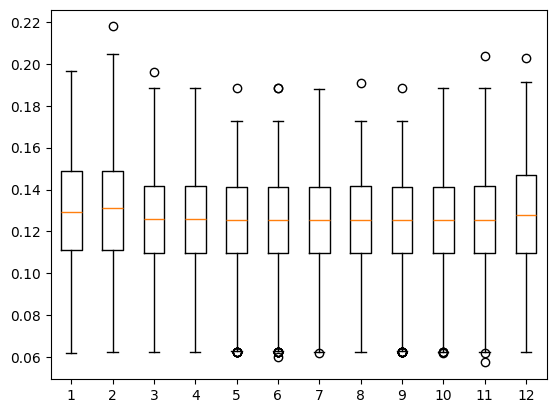

In [26]:
plt.boxplot(prediction_times.values(), showfliers=True)
plt.show()